# Convolutional Neural Network (CNN) for Urban Waste Classification

## 1) Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random
import seaborn as sns
import warnings
import shutil
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image

warnings.simplefilter('ignore')

## 2) Data understanding

### 2.1) Data Collection

In [2]:
path = r'garbage_classification'
all_folds = os.listdir(path)

### 2.2) Exploratory Data Analysis

In [11]:
def data_info(path, all_folds):

    img_list = glob.glob(os.path.join(path, '*/*.jpg'))

    df = pd.DataFrame()
    df['Class'] = [fold for fold in all_folds]
    df['Files'] = [
        len(os.listdir(os.path.join(path, fold))) for fold in all_folds
    ]
    df = df.sort_values(by='Files', ascending=True)

    fig = make_subplots(rows=2,
                        cols=2,
                        column_widths=[0.6, 0.4],
                        row_heights=[0.4, 0.6],
                        specs=[[{
                            "type": "bar",
                            "rowspan": 2
                        }, {
                            "type": "indicator"
                        }], [None, {
                            "type": "indicator"
                        }]])

    fig.add_trace(
        go.Bar(x=df['Files'], 
               y=df['Class'], 
               orientation='h',
              text = df['Files'],
              textposition = 'inside'),
        row=1,
        col=1,
    )

    fig.add_trace(go.Indicator(value=len(img_list),
                               title={'text': 'Number of images'}),
                  row=1,
                  col=2)

    fig.add_trace(go.Indicator(value=len(all_folds),
                               title={'text': 'Number of classes'}),
                  row=2,
                  col=2)

    fig.update_layout(margin=dict(r=10, t=25, b=40, l=60),
                      plot_bgcolor='rgba(0,0,0,0)')

    fig.show("png")

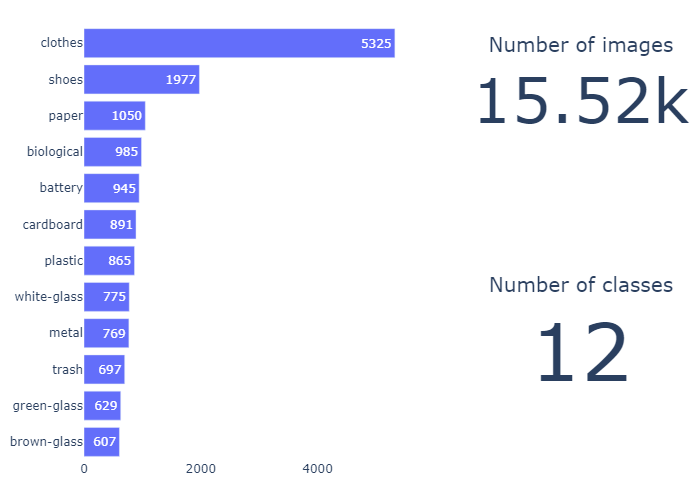

In [12]:
data_info(path, all_folds)

In [7]:
def img_examples(path, all_folds):
    
    print('Image examples: ')

    i = 0

    plt.figure(figsize=(15, 15))

    for fold in all_folds:

        directory = os.path.join(path, fold)

        img_path = os.path.join(path, fold,
                                random.choice(os.listdir(directory)))
        img = load_img(img_path)

        img = img_to_array(img, dtype=np.uint8)

        plt.subplot(3, 4, i + 1)

        plt.imshow(img.squeeze())

        plt.title(fold)

        plt.axis("off")

        i = i + 1

Image examples: 


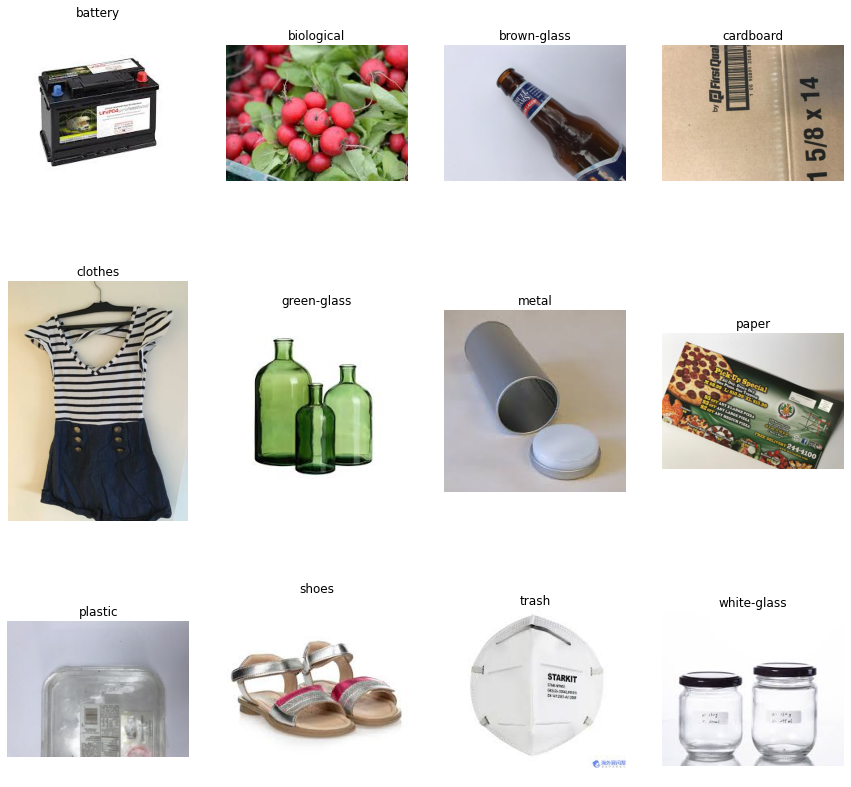

In [8]:
img_examples(path, all_folds)

## 3) Data Wrangling

### 3.1) Merging folds

#### 3.1.1) Cardboard and paper

Since cardboard and paper are made from the same material and have similar shape, we can consider both as just one class. Let's create a single directory for both and move the data to it.

In [13]:
cardboard_and_paper = os.path.join(path, 'cardboard-and-paper')

os.mkdir(cardboard_and_paper)


for fold in ["cardboard","paper"]:
    
    directory = os.path.join(path, fold)
    
    for file in os.listdir(directory):
    
        source = os.path.join(directory, file)
    
        shutil.move(source, cardboard_and_paper)
    
    os.rmdir(directory)

#### 3.1.2) Brown, green and white glass

The same criteria can be used for brown, green and white glass. Both are the same material and have the same shape and purpose with just different colors. We can simply move them all in a single directory called glass.

In [14]:
glass = os.path.join(path, 'glass')

os.mkdir(glass)


for fold in ["brown-glass","green-glass","white-glass"]:
    
    directory = os.path.join(path, fold)
    
    for file in os.listdir(directory):
    
        source = os.path.join(directory, file)
    
        shutil.move(source, glass)
    
    os.rmdir(directory)

### 3.1) Dropping folds

The directory 'trash' has images from different materials and shapes. In order to have classes with more balanced images, this directory will be removed from the analysis

In [15]:
directory = os.path.join(path, 'trash')

shutil.rmtree(directory)

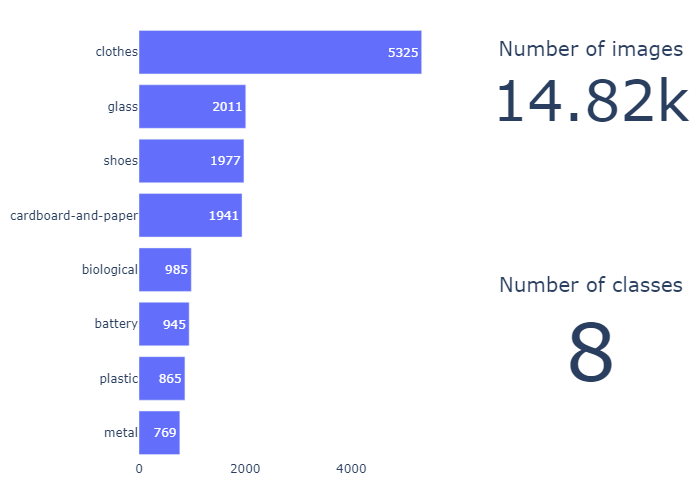

Image examples: 


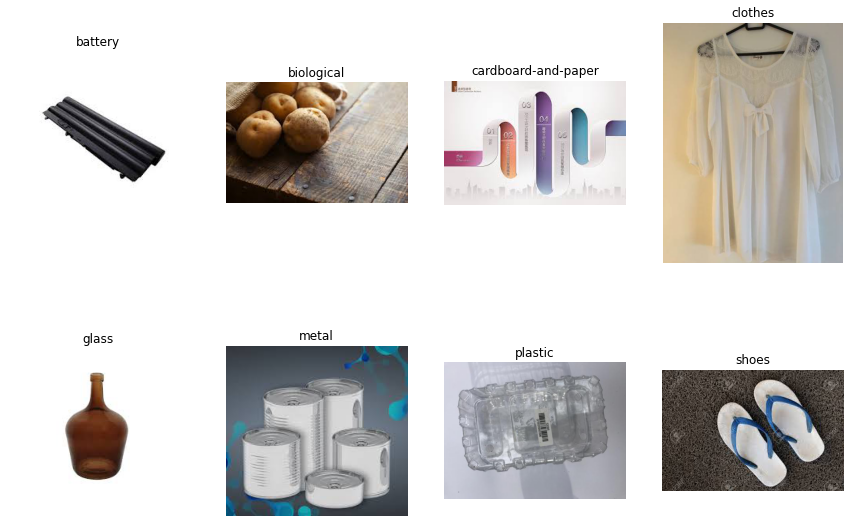

In [16]:
all_folds = os.listdir(path)
data_info(path, all_folds)
img_examples(path, all_folds)

### 3.2) Dealing with imbalanced data

The labels of the dataset are imbalanced. The fold with clothes data have 5325 imagens while the fold with metal has only 769 images. In order to take a more balanced dataset, let's use undersampling technique to take only 769 random images from each fold and pass them to another directory.

First, let's create the new directory that will host the new folders for the balanced data:

In [17]:
new_directory = os.path.join(path, 'balanced_data')

os.mkdir(new_directory)

new_directory

'garbage_classification\\balanced_data'

Now, let's take 769 examples from each fold from the old directory and move them to new folds in the new directory

In [18]:
def move_folds(path, all_folds2):

    for fold in all_folds2:

        directory = os.path.join(path, fold)

        random_files = random.sample(os.listdir(directory), 769)

        new_fold = os.path.join(new_directory, fold)

        os.mkdir(new_fold)

        for file in random_files:

            source = os.path.join(directory, file)

            shutil.copy(source, new_fold)

In [19]:
move_folds(path, all_folds)

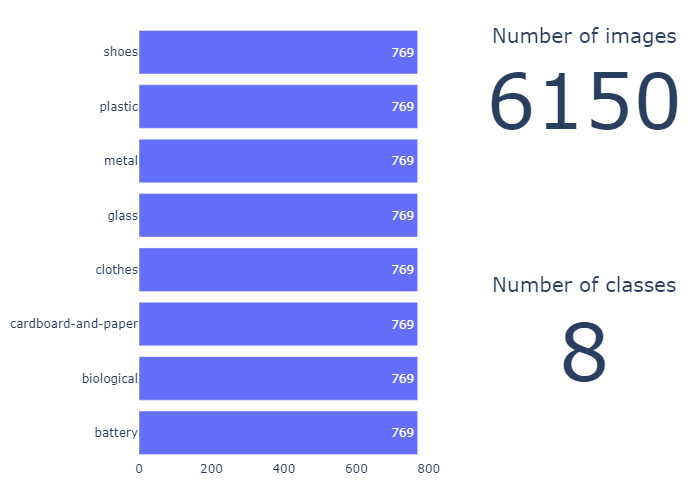

Image examples: 


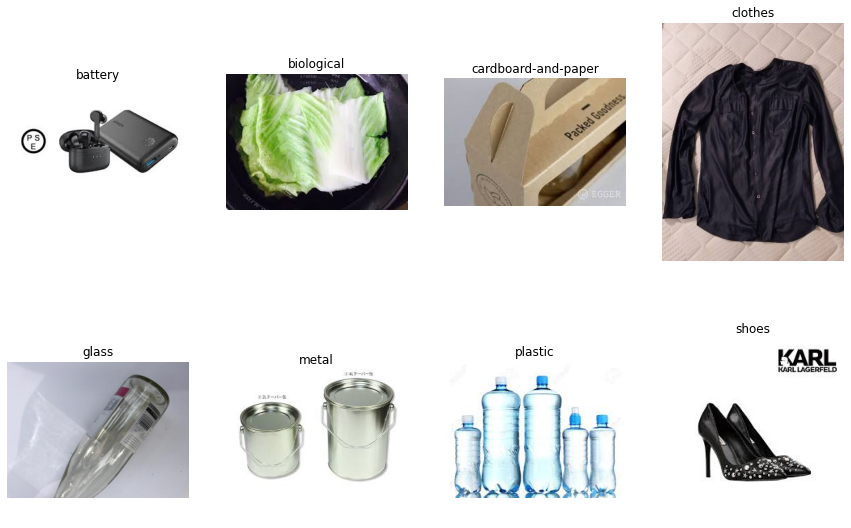

In [20]:
path = new_directory
data_info(path, all_folds)
img_examples(path, all_folds)

### 3.3) Data augmentation

In [255]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 1.2],
                             validation_split=0.2)

In [256]:
img_width = 256

img_height = 256

train = datagen.flow_from_directory(path,
                                    target_size=(img_width, img_height),
                                    batch_size=128,
                                    class_mode='binary',
                                    subset='training')

val = datagen.flow_from_directory(path,
                                  target_size=(img_width, img_height),
                                  batch_size=128,
                                  class_mode='binary',
                                  subset='validation')

Found 4928 images belonging to 8 classes.
Found 1224 images belonging to 8 classes.


(-0.5, 317.5, 158.5, -0.5)

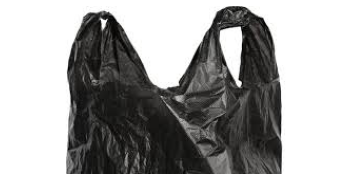

In [272]:
fold_path = os.path.join(path, random.choice(all_folds))
img_path = os.path.join(fold_path, random.choice(os.listdir(fold_path)))
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')

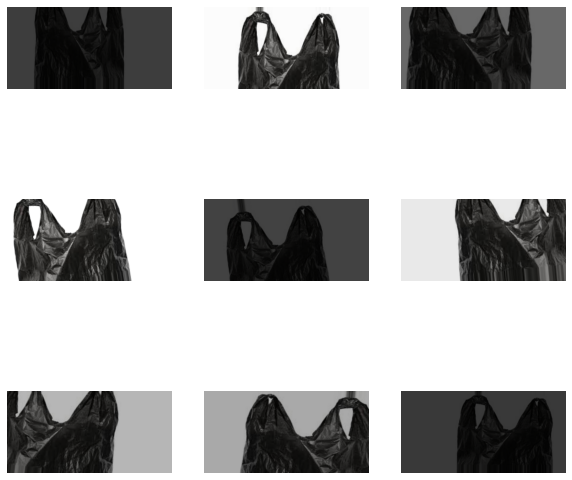

In [273]:
img = img_to_array(img)

samples = np.expand_dims(img, 0)

img_batches = datagen.flow(samples, batch_size=1)

plt.figure(figsize=(10, 10))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    batch = img_batches.next()

    image = batch[0].astype('uint8')

    plt.imshow(image)

    plt.axis('off')

plt.show()

## 4) Modeling

In [275]:
baseModel = tf.keras.applications.ResNet50(input_shape=(256, 256, 3),
                                           weights='imagenet',
                                           include_top=False,
                                           classes=train.num_classes)

In [276]:
for layers in baseModel.layers[:-6]:
    layers.trainable = False

In [277]:
last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.45) (last_output)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.BatchNormalization() (x)

x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)

x = tf.keras.layers.Dropout(0.45) (x)

x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

In [278]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
              optimizer=Adam(),
              metrics=['accuracy'])

In [279]:
epochs = 30
history = model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/30
39/39 [==============================] - 792s 21s/step - loss: 300.7571 - accuracy: 0.7047 - val_loss: 91.7742 - val_accuracy: 0.7900
Epoch 2/30
39/39 [==============================] - 729s 19s/step - loss: 33.4967 - accuracy: 0.8070 - val_loss: 9.1593 - val_accuracy: 0.7451
Epoch 3/30
39/39 [==============================] - 723s 19s/step - loss: 6.4260 - accuracy: 0.7719 - val_loss: 5.4997 - val_accuracy: 0.7247
Epoch 4/30
39/39 [==============================] - 788s 20s/step - loss: 5.3701 - accuracy: 0.7595 - val_loss: 5.3948 - val_accuracy: 0.6879
Epoch 5/30
39/39 [==============================] - 779s 20s/step - loss: 5.3338 - accuracy: 0.7567 - val_loss: 5.3296 - val_accuracy: 0.7729
Epoch 6/30
39/39 [==============================] - 794s 20s/step - loss: 5.2962 - accuracy: 0.7681 - val_loss: 5.3009 - val_accuracy: 0.7663
Epoch 7/30
39/39 [==============================] - 810s 21s/step - loss: 5.2494 - accuracy: 0.7723 - val_loss: 5.3068 - val_accuracy: 0.7500
Ep

## 5) Evaluation

In [280]:
model.evaluate(val)

10/10 [==============================] - 156s 15s/step - loss: 4.7581 - accuracy: 0.8562


[4.758084774017334, 0.8562091588973999]

In [283]:
model.save('Users\henrique.maciel\garbage_classification')

INFO:tensorflow:Assets written to: Users\henrique.maciel\garbage_classification\assets


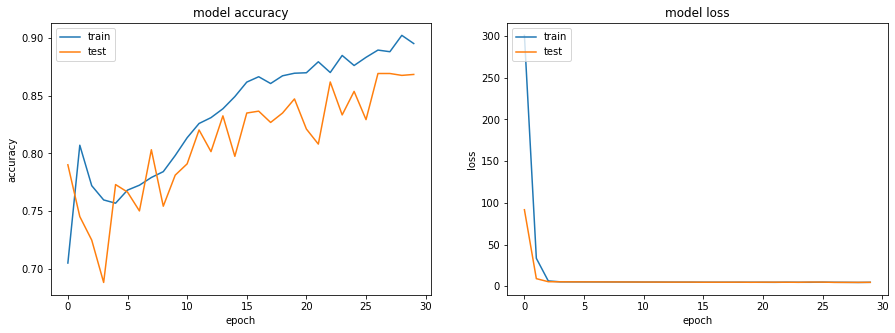

In [284]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()